# Оборот сапфиров

### Исходные данные:
- У вас есть данные продаж фирмы за последние 2 года (Оборот_сапфиров.csv), а также данные стоимости изделий за 2 прошлых года и на год вперёд (Стоимость_драгоценностей_из_сапфиров.csv). 
- сегодня 1.01.2019

### Задача:
- предсказать оборот сапфиров за 2019 год. Постройте график значений оборота сапфиров по месяцам

### Содержание

## <a href='#section01'>1. Изучение общей информации</a>
* <a href='#section1'>1. Загрузка библиотек и функций, чтение информации</a>
* <a href='#section2'>2. Просмотр данных</a>
* <a href='#section3'>3. Выявление аномалий</a>
* <a href='#section4'>4. Вывод</a>

## <a href='#section02'>2. Предсказание</a>
* <a href='#section21'>1. Предсказать оборот по месяцам, используя сезонность</a>
* <a href='#section22'>2. Предсказать оборот по дням, используя сезонность и данные по стоимости изделий</a>

## <a href='#section03'>3. Итоговый вывод</a>

<hr style="border: 1px solid #000;">

## <a id=section01>1. Изучение общей информации</a>

### <a id=section1>1. Загрузка библиотек и функций, чтение информации</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from scipy.optimize import minimize

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_validate as cval, cross_val_predict as cvp
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool, cv
from lightgbm import LGBMRegressor

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 50)

rs=12345

Загрузил библиотеки и необходимые настройки

In [3]:
def missing_value(df):
    missing_value = pd.DataFrame(columns=['NaN_part', 'empty_counts', 'space_counts', '0_counts', '-1_counts', 'unique_counts',\
                                          'min_value', 'max_value', 'dupl_sum', 'dtypes', 'length'], index=df.columns)
    for i in df.columns: 
        missing_value['NaN_part'][i] = df[i].isnull().mean()
        missing_value['empty_counts'][i] = df[df[i] == ''][i].count()
        missing_value['space_counts'][i] = df[df[i] == ' '][i].count()
        missing_value['0_counts'][i] = df[(df[i] == 0)][i].count()
        missing_value['-1_counts'][i] = df[df[i] == -1][i].count()
        missing_value['unique_counts'][i] = len(df[i].unique())
        missing_value['min_value'][i] = df[i].min()
        missing_value['max_value'][i] = df[i].max()
        missing_value['dupl_sum'][i] = df[i].duplicated().sum()
        missing_value['dtypes'][i] = df[i].dtypes
        missing_value['length'][i] = len(df[i])
    display(missing_value)

Функция поиска аномалий в данных

In [4]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return

Функция определения критерия Дики-Фуллера

In [5]:
turnover = pd.read_csv('datasets/turnover_sapphires.csv', parse_dates=[0], index_col=[0])
calendar = pd.read_csv('datasets/calendar.csv', parse_dates=[0], index_col=[0])
cost_jewelry = pd.read_csv('datasets/cost_sapphires_jewelry.csv', parse_dates=[0], index_col=[0])

### <a id=section2>2. Просмотр данных</a>

In [6]:
turnover.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 2017-01-02 to 2018-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Оборот  727 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


Существуют 2 пропуска в таблице turnover

In [7]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2017-01-01 to 2019-12-31
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   День_недели  1095 non-null   int64
 1   Праздник     1095 non-null   int64
 2   Неделя       1095 non-null   int64
dtypes: int64(3)
memory usage: 34.2 KB


In [8]:
cost_jewelry.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1076 entries, 2017-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Стоимость  1076 non-null   float64
dtypes: float64(1)
memory usage: 16.8 KB


In [9]:
turnover

,Оборот
Дата,
2017-01-02,48130.0
2017-01-03,145180.0
2017-01-04,541630.0
2017-01-05,157780.0
2017-01-06,70540.0
...,...
2018-12-27,9579400.0
2018-12-28,10394860.0
2018-12-29,8208580.0


In [10]:
calendar

,День_недели,Праздник,Неделя
Дата,,,
2017-01-01,7,1,1
2017-01-02,1,1,2
2017-01-03,2,1,2
2017-01-04,3,1,2
2017-01-05,4,1,2
...,...,...,...
2019-12-27,5,0,52
2019-12-28,6,1,52
2019-12-29,7,1,52


In [11]:
cost_jewelry

,Стоимость
Date,
2017-01-01,2.892925e+06
2017-01-02,2.979921e+03
2017-01-03,3.035001e+03
2017-01-04,3.091300e+03
2017-01-05,3.421105e+06
...,...
2019-12-27,2.150112e+04
2019-12-28,2.163188e+04
2019-12-29,2.188468e+04


### <a id=section3>3. Выявление аномалий</a>

In [12]:
missing_value(turnover) 

,NaN_part,empty_counts,space_counts,0_counts,-1_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
Оборот,0.00274348,0,0,0,0,727,6700,4.87464e+07,2,float64,729


In [13]:
missing_value(calendar)

,NaN_part,empty_counts,space_counts,0_counts,-1_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
День_недели,0,0,0,0,0,7,1,7,1088,int64,1095
Праздник,0,0,0,741,0,2,0,1,1093,int64,1095
Неделя,0,0,0,0,0,53,1,53,1042,int64,1095


In [14]:
missing_value(cost_jewelry) 

,NaN_part,empty_counts,space_counts,0_counts,-1_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
Стоимость,0,0,0,0,0,1071,2267.98,4.46446e+07,5,float64,1076


Посмотрю график turnover

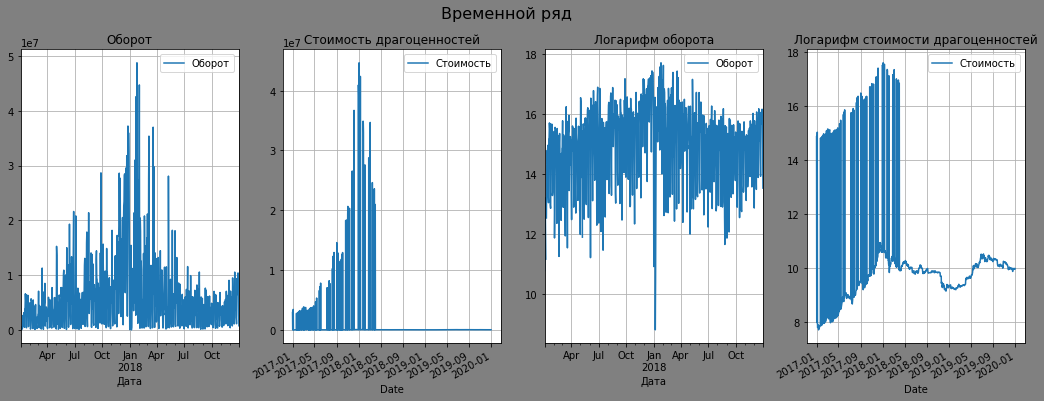

In [15]:
fig = plt.figure(figsize=(18, 6), facecolor='gray')
fig.suptitle('Временной ряд', fontsize=16)
plt.subplots_adjust(wspace=0.2, hspace=0.3)

ax = fig.add_subplot(1, 4, 1)
turnover.plot(ax=ax)
ax=plt.gca()
ax.grid()
ax.set_title('Оборот')

ax = fig.add_subplot(1, 4, 2)
cost_jewelry.plot(ax=ax)
ax=plt.gca()
ax.grid()
ax.set_title('Стоимость драгоценностей')

ax = fig.add_subplot(1, 4, 3)
np.log(turnover).plot(ax=ax)
ax=plt.gca()
ax.grid()
ax.set_title('Логарифм оборота')

ax = fig.add_subplot(1, 4, 4)
np.log(cost_jewelry).plot(ax=ax)
ax=plt.gca()
ax.grid()
ax.set_title('Логарифм стоимости драгоценностей')

plt.show()

In [16]:
display(turnover[turnover['Оборот'].isnull()])

,Оборот
Дата,
2017-01-07,NaN
2017-05-09,NaN


Аномалий нет. Можно только:
- перевести на русский признаки
- предобработать NaN в столбце Оборот таблицы turnover
- странные данные в таблице cost_jewelry. Возможно аномалия. Стоимость изделий в некоторые дни на 3 порядка отличается от других данных.

Из таблиц видно:
- в turnover данные начинаются со 2 января 2017 года. 
- в turnover данные за 2 года
- в таблице calendar есть данные за все дни за 3 года
- в таблице cost_jewelry данные за 3 года
- в таблице cost_jewelry отсутствует ряд данных за 1095 - 1076 = 19 дней.

In [17]:
cost_jewelry.rename(columns={'Date': 'Дата'}, inplace=True)

In [18]:
turnover = turnover.ffill() 
display(turnover.head())

,Оборот
Дата,
2017-01-02,48130.0
2017-01-03,145180.0
2017-01-04,541630.0
2017-01-05,157780.0
2017-01-06,70540.0


In [19]:
missing_value(turnover) 

,NaN_part,empty_counts,space_counts,0_counts,-1_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
Оборот,0,0,0,0,0,726,6700,4.87464e+07,3,float64,729


In [20]:
turnover.sort_index(inplace=True)

### <a id=section4>4. Вывод</a>

Предобработка выполнена.

<hr style="border: 1px solid #000;">

## <a id=section02>2. Предсказание</a>

У меня есть данные по обороту продаж сапфиров за 2017-2018 годы. Посмотрим на график:

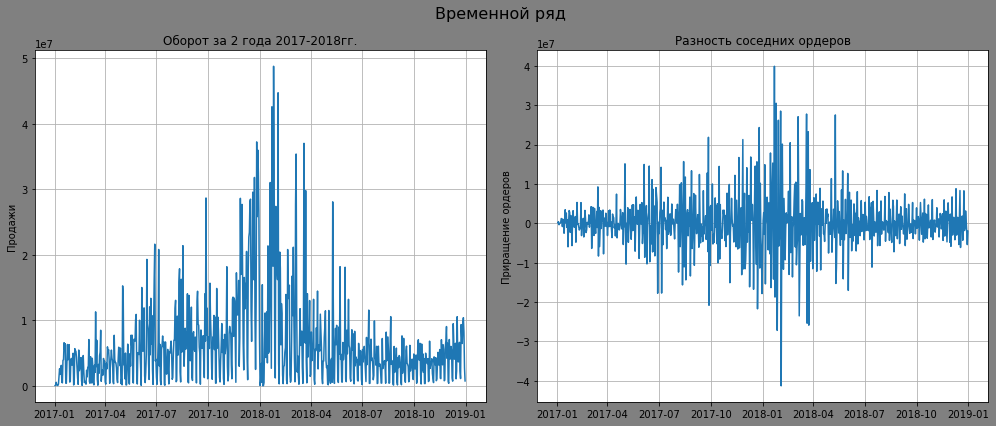

In [21]:
# turnover['date'] = pd.to_datetime(taxi.index)
fig, axes = plt.subplots(1,2, tight_layout=True, figsize=(14, 6), facecolor='gray')
fig.suptitle('Временной ряд', fontsize=16)
plt.subplots_adjust(wspace=0.2, hspace=0.3)

axes[0].plot(turnover['Оборот'])
axes[0].set_title('Оборот за 2 года 2017-2018гг.')
axes[0].set_ylabel('Продажи')
axes[0].grid()

axes[1].plot(turnover['Оборот'].diff())
axes[1].set_title('Разность соседних ордеров')
axes[1].set_ylabel('Приращение ордеров')
axes[1].grid()

На всем промежутке времени виден достаточно высокий разброс оборота. Зимой 2018 года был достаточно высокий всплеск. К январю 2019 года всплеск упал почти до нуля. В январе 2017 года также не видно активности. В целом ряд не блуждает, ходит вокруг одной величины. Можно предположить, что данный временной ряд является стационарным.

Разность соседних дневных продаж при этом имеет сильное расхождение. Стандартное его отклонение изменяется, что говорит в пользу нестационарности ряда

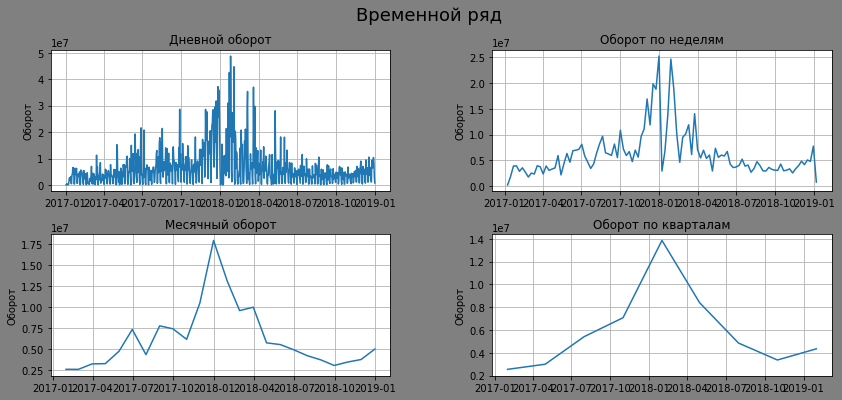

In [22]:
fig, axes = plt.subplots(2,2, figsize=(14,6), facecolor='gray')
fig.suptitle('Временной ряд', fontsize=18)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

axes[0, 0].plot(turnover.resample('1D').mean())
axes[0, 0].set_title('Дневной оборот')
axes[0, 0].set_ylabel('Оборот')
axes[0, 0].grid()

axes[0, 1].plot(turnover.resample('1W').mean())
axes[0, 1].set_title('Оборот по неделям')
axes[0, 1].set_ylabel('Оборот')
axes[0, 1].grid()

axes[1, 0].plot(turnover.resample('1M').mean())
axes[1, 0].set_title('Месячный оборот')
axes[1, 0].set_ylabel('Оборот')
axes[1, 0].grid()

axes[1, 1].plot(turnover.resample('3M').mean())
axes[1, 1].set_title('Оборот по кварталам')
axes[1, 1].set_ylabel('Оборот')
axes[1, 1].grid()
plt.show()

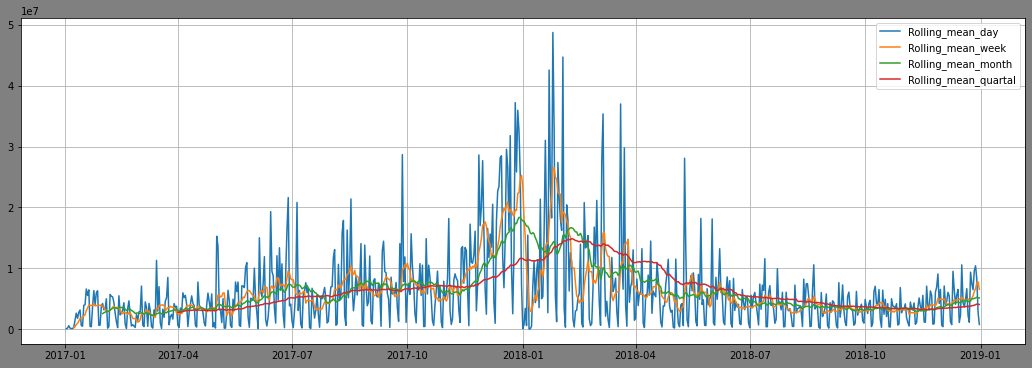

In [23]:
fig = plt.figure(figsize=(18,6), facecolor='gray')
ax = plt.plot(turnover, label='Rolling_mean_day')
plt.plot(turnover.rolling(7).mean(), label='Rolling_mean_week')
plt.plot(turnover.rolling(30).mean(), label='Rolling_mean_month')
plt.plot(turnover.rolling(90).mean(), label='Rolling_mean_quartal')
plt.grid()
plt.legend(loc='best')
plt.show()

Из графиков оборота видно, что до 2018 года оборот рос, а после начал падать. Изменяется средняя величина и стандартное отклонение.

Сглаживание по неделям позволяет увидеть изменение оборота в праздничные и выходные дни. 
Сглаживание по месяцам позволяет оценить месячные изменения оборота.
Сглаживание по кварталам позволяет оценить сезонные изменения оборота.

В данном случае период всего 2 года занимает. Видно, что продажи росли до 2018 года с заметным периодом просадки в новогодние праздничные дни. Затем оборот начал падать, хотя отдельные всплески в марте и даже мае еще были. 

In [24]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

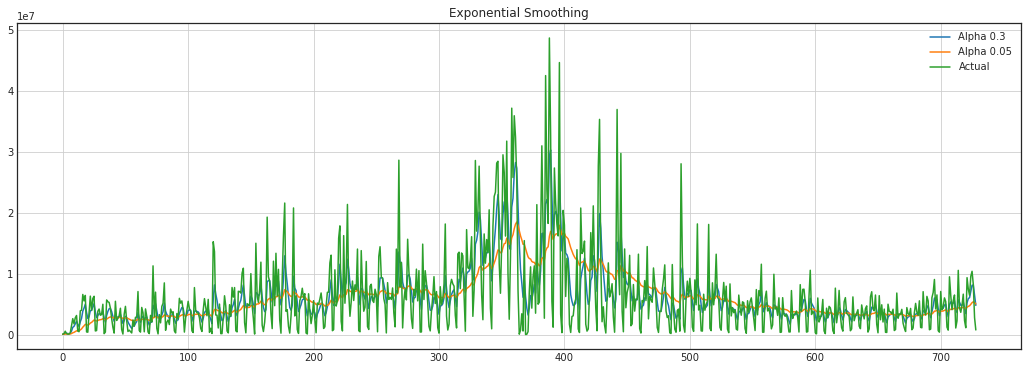

In [25]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(18, 6))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(turnover['Оборот'], alpha), label="Alpha {}".format(alpha))
    plt.plot(turnover['Оборот'].values, label="Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

In [26]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

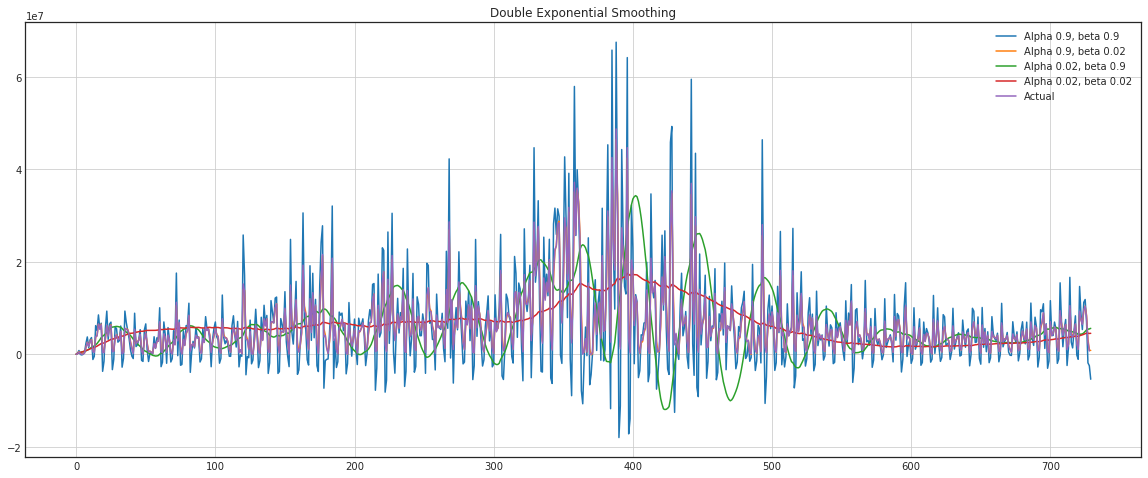

In [27]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(turnover['Оборот'], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(turnover['Оборот'].values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [28]:
row =  ['JB', 'p-value', 'skew', 'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(turnover['Оборот'])
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print(itog)

        JB        p-value        skew            kurtosis     
--------------------------------------------------------------
2653.630518248165     0.0 2.458926283398087 10.948399066458178
--------------------------------------------------------------


С вероятностью 0% нулевая гипотеза о нормальности распределения могла случайно оказаться верной. Отвергаем нулевую гипотезу и принимаем альтернативную.

Проведу тест Дикки-Фуллера на стационарность ряда. Нулевая гипотеза заключается в том, что ряд стационарен, альтернативная - нестационарен. 

In [29]:
test = sm.tsa.adfuller(turnover['Оборот'])
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.5356719927562983
p-value:  0.007116853432786493
Critical values:  {'1%': -3.43955476721974, '5%': -2.865602155751202, '10%': -2.5689331692727135}
единичных корней нет, ряд стационарен


In [30]:
otg1diff = turnover['Оборот'].diff(periods=1).dropna()
otg1diff

Дата
2017-01-03      97050.0
2017-01-04     396450.0
2017-01-05    -383850.0
2017-01-06     -87240.0
2017-01-07          0.0
                ...    
2018-12-27    3118470.0
2018-12-28     815460.0
2018-12-29   -2186280.0
2018-12-30   -5442120.0
2018-12-31   -2015520.0
Name: Оборот, Length: 728, dtype: float64

In [31]:
m = otg1diff.index[int(len(otg1diff)/2)]
r1 = sm.stats.DescrStatsW(otg1diff[m:])
r2 = sm.stats.DescrStatsW(otg1diff[:m])
print('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  0.9998629186821795


Высокое p-value дает нам возможность утверждать, что нулевая гипотеза о равенстве средних верна, что свидетельствует о стационарности ряда.

Критерий Дики-Фуллера: p=0.007117


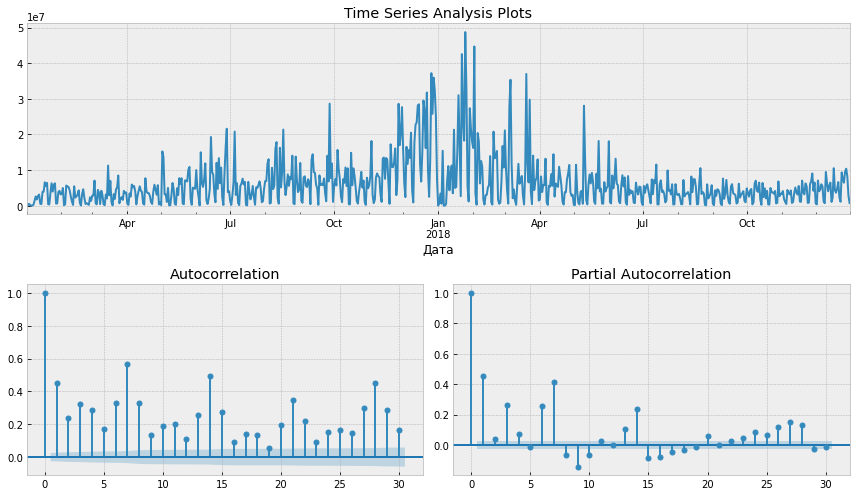

In [32]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(turnover['Оборот'], lags=30)

Критерий Дикки-Фуллера также позволяет принят гипотезу о стационарности ряда

Рассмотрю отдельно трендовую, сезонную и остаточную составляющие

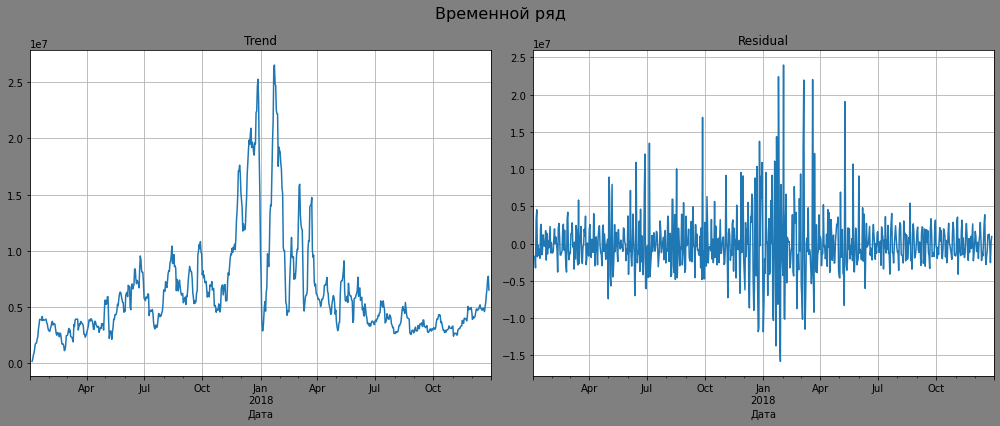

In [33]:
turnover_decomposed = seasonal_decompose(turnover)

fig = plt.figure(figsize=(14, 6), facecolor='gray')
fig.suptitle('Временной ряд', fontsize=16)
plt.subplots_adjust(wspace=0.2, hspace=0.3)

ax = fig.add_subplot(1, 2, 1)
ax=plt.gca()
turnover_decomposed.trend.plot(ax=ax);
ax.set_title('Trend')
ax.grid(True)

ax = fig.add_subplot(1, 2, 2)
ax=plt.gca()
turnover_decomposed.resid.plot(ax=ax);
ax.set_title('Residual')
ax.grid(True)
plt.tight_layout()
plt.show()

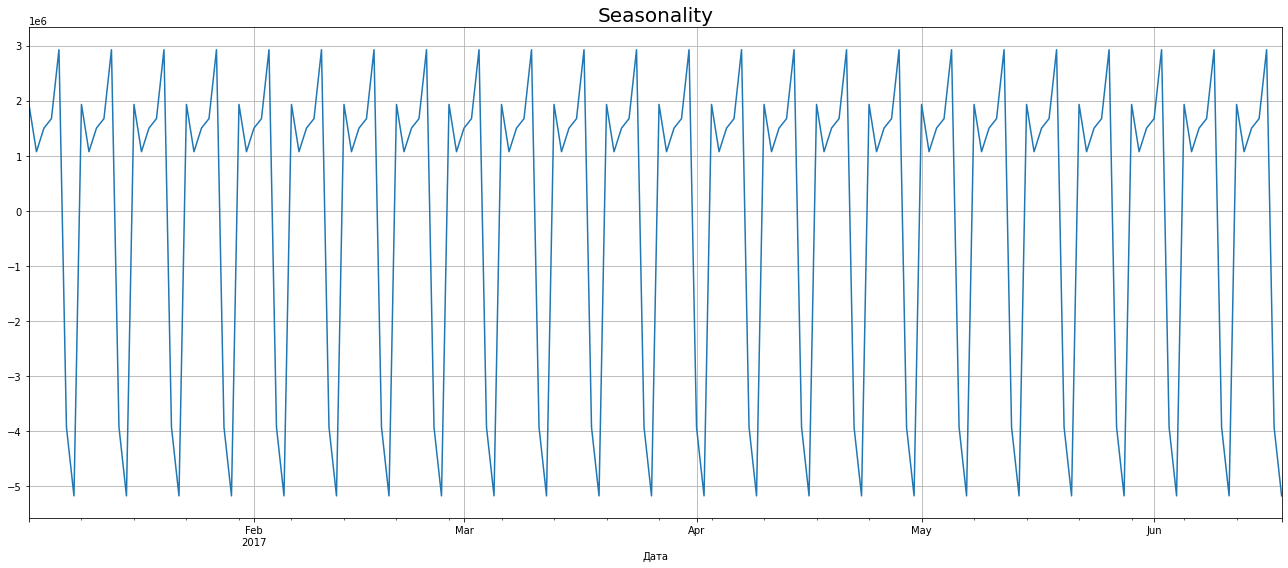

In [34]:
plt.figure(figsize=(18, 8))
turnover_decomposed.seasonal[0:168].plot(ax=plt.gca());
plt.title('Seasonality', fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

из графика сезонной составляющей видно, что длительность цикла сезонности составляет 1 неделю. Рассмотрю доверительный интервал на квартальной скользящей средней

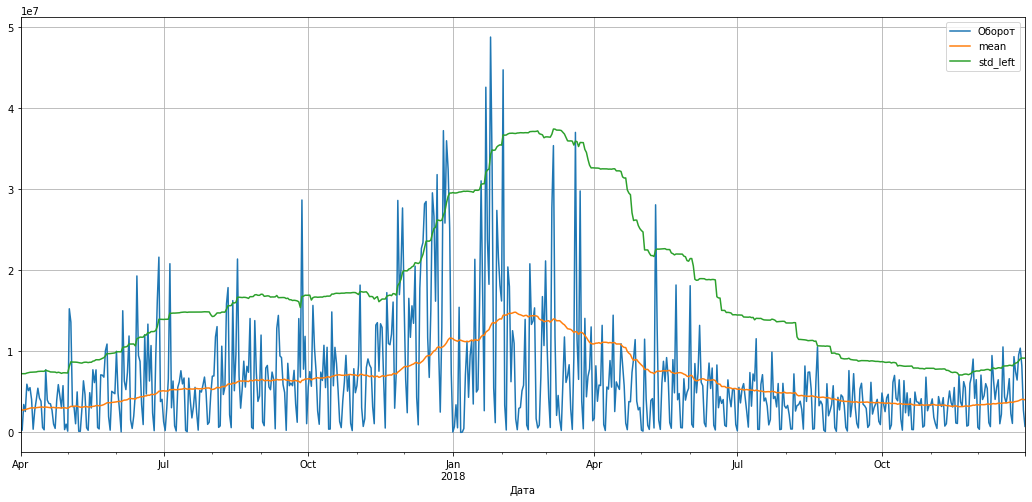

In [35]:
plt.figure(figsize=(18, 8))
df = turnover.copy()
days = 90

df['mean'] = df['Оборот'].rolling(days).mean()
df['std'] = df['Оборот'].rolling(days).std()
df.dropna(inplace=True)
df['std_left'] = df['mean'] + 1.96 * df['std']
data = df[['Оборот', 'mean', 'std_left']]
data.plot(ax=plt.gca());
plt.grid(True)
plt.show();

Видно, что до 2018 года было много аномальных продаж, выходящих за пределы доверительного интервала квартальной скользящей средней.

Вывод: Рассмотрен ряд на стационарность

- Временной ряд стационарный
- сезонность составляет 1 неделю
- продажи росли до 2018 года, потом падали. В конце 2019 года начался небольшой рост

Обогащу признаковое пространство. Добавлю лаги, роллинг и разобью дату. Я имею недельную сезонность на двухгодичном периоде. Можно было бы не использовать информацию о годе, если бы не ломался тренд. Возьму данные по дате за день, неделю, месяц и год.

In [36]:
def make_features(data, target, lag_list, roll_list):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['week'] = data.index.week
    data['month'] = data.index.month
    data['year'] = data.index.year
    
    for lag in lag_list:
        data['lag_' + str(lag)] = data[target].shift(lag)
    for roll in roll_list:
        data['roll_' + str(roll)] = data[target].shift().rolling(roll).mean()
    
#     data['double_exp'] = double_exponential_smoothing(turnover['Оборот'], 0.9, 0.02)
    data = data.dropna()
    return data

In [37]:
turnover_df = make_features(turnover, 'Оборот', [1, 2, 3, 7, 14, 30], [7])

In [38]:
display(turnover_df.head())

,Оборот,day,dayofweek,week,month,year,lag_1,lag_2,lag_3,lag_7,lag_14,lag_30,roll_7
Дата,,,,,,,,,,,,,
2017-02-01,3170170.0,1,2,5,2,2017,4189240.0,3831880.0,652690.0,3980590.0,6583750.0,48130.0,3.637210e+06
2017-02-02,3287020.0,2,3,5,2,2017,3170170.0,4189240.0,3831880.0,5934040.0,5523730.0,145180.0,3.521436e+06
2017-02-03,4974280.0,3,4,5,2,2017,3287020.0,3170170.0,4189240.0,6285250.0,6430330.0,541630.0,3.143290e+06
2017-02-04,142810.0,4,5,5,2,2017,4974280.0,3287020.0,3170170.0,586780.0,425020.0,157780.0,2.956009e+06
2017-02-05,400810.0,5,6,5,2,2017,142810.0,4974280.0,3287020.0,652690.0,383050.0,70540.0,2.892584e+06


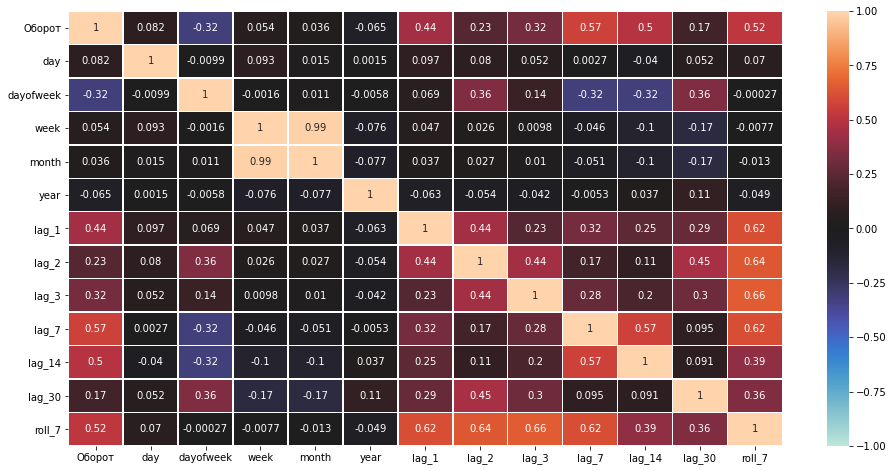

In [40]:
fig = plt.figure(figsize = (16,8))
sns.heatmap(turnover_df.corr(), vmin=-1, vmax=1, center=0, annot=True, linewidths=0.5)
plt.show();

Подобрал такие лаги и сдвиги, чтобы их коллинеарность не была выше 0.75. Теперь можно приступать к обучению

### <a id=section21>1. Предсказать оборот по месяцам, используя сезонность</a>

In [41]:
features = turnover_df.drop('Оборот', axis=1)
target = turnover_df['Оборот']

features_train, features_test, target_train, target_test = train_test_split(features, target, train_size=0.75, 
                                                                            shuffle=False, random_state=rs)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(524, 12)
(175, 12)
(524,)
(175,)


In [42]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = pd.DataFrame(scaler.transform(features_train), columns=features_train.columns, index=features_train.index)
features_test = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns, index=features_test.index)
features_train

,day,dayofweek,week,month,year,lag_1,lag_2,lag_3,lag_7,lag_14,lag_30,roll_7
Дата,,,,,,,,,,,,
2017-02-01,-1.644163,-0.501909,-1.324111,-1.199619,-0.754230,-0.402553,-0.450862,-0.870823,-0.429683,-0.086590,-0.936592,-0.758419
2017-02-02,-1.530608,-0.001908,-1.324111,-1.199619,-0.754230,-0.537349,-0.403568,-0.450227,-0.171381,-0.226783,-0.923814,-0.782847
2017-02-03,-1.417053,0.498093,-1.324111,-1.199619,-0.754230,-0.521893,-0.538435,-0.402949,-0.124941,-0.106881,-0.871616,-0.862633
2017-02-04,-1.303498,0.998093,-1.324111,-1.199619,-0.754230,-0.298712,-0.522971,-0.537769,-0.878441,-0.901114,-0.922155,-0.902148
2017-02-05,-1.189943,1.498094,-1.324111,-1.199619,-0.754230,-0.937789,-0.299672,-0.522310,-0.869726,-0.906665,-0.933641,-0.915530
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-05,-1.189943,-0.001908,0.262620,0.371097,1.325856,-0.243876,-0.475760,-0.222483,-0.244712,-0.482379,-0.299829,-0.730855
2018-07-06,-1.076388,0.498093,0.262620,0.371097,1.325856,-0.160289,-0.244807,-0.475116,-0.266006,-0.420532,0.021152,-0.711525
2018-07-07,-0.962833,0.998093,0.262620,0.371097,1.325856,-0.387938,-0.161176,-0.244244,-0.825690,-0.840313,0.795186,-0.739216


In [43]:
tscv = TimeSeriesSplit()

In [44]:
dummy = DummyRegressor(strategy='median')
n_scores_dummy = pd.DataFrame(cval(dummy, features_train, target_train, cv=tscv.n_splits, scoring=('neg_mean_squared_error'), 
                                   return_train_score=True)).abs()


train_RMSE_dummy = n_scores_dummy.train_score.mean() ** 0.5
valid_RMSE_dummy = n_scores_dummy.test_score.mean() ** 0.5

print(f'RMSE dummy на обучающей выборке: {train_RMSE_dummy}')
print(f'RMSE dummy на валидационной выборке: {valid_RMSE_dummy}')

RMSE dummy на обучающей выборке: 7779662.573310467
RMSE dummy на валидационной выборке: 7963682.086511343


In [45]:
%%time
rfr = RandomForestRegressor(random_state=rs)
params = {'n_estimators': [i for i in range(50, 1000, 10)],
          'max_depth': [i for i in range(2, 7, 1)]}

gs = GridSearchCV(rfr, params, scoring=('neg_mean_squared_error'), n_jobs=-1, cv=5)
gs.fit(features_train, target_train)

Wall time: 11min 2s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120,
                                          130, 140, 150, 160, 170, 180, 190,
                                          200, 210, 220, 230, 240, 250, 260,
                                          270, 280, 290, 300, 310, 320, 330,
                                          340, ...]},
             scoring='neg_mean_squared_error')

In [46]:
gs.best_params_

{'max_depth': 6, 'n_estimators': 960}

RMSE на обучающей выборке: 3215552.8789048255
RMSE на валидационной выборке: 5833070.685196299
RMSE предсказание на тестовой выборке: 1895817.3494837764
RMSE предсказание на train: 5828570.292959801


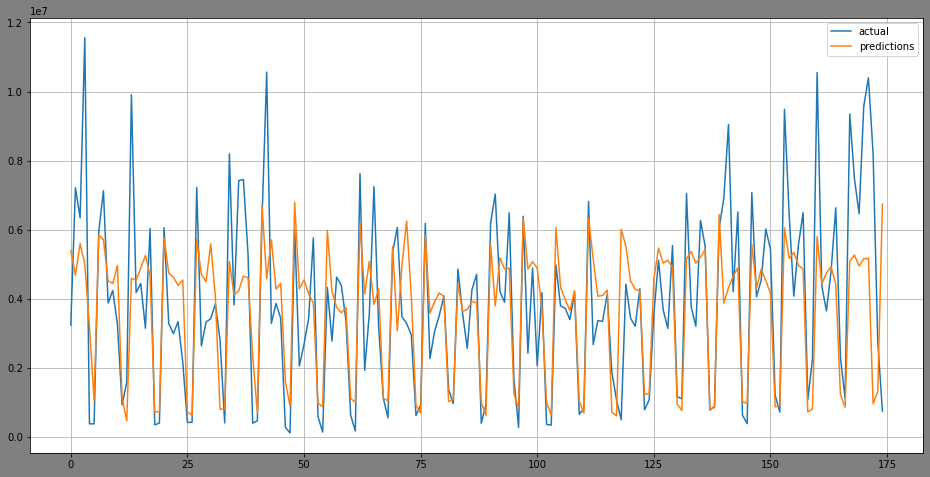

In [47]:
model = RandomForestRegressor(**gs.best_params_)
model.fit(features_train, target_train)

n_scores = pd.DataFrame(cval(model, features_train, target_train, cv=tscv.n_splits, scoring=('neg_mean_squared_error'), 
                                return_train_score=True)).abs()
target_pred = pd.DataFrame(cvp(model, features_test, target_test, cv=tscv.n_splits))
train_pred = pd.DataFrame(cvp(model, features_train, target_train, cv=tscv.n_splits))

train_RMSE = n_scores.train_score.mean() ** 0.5
valid_RMSE = n_scores.test_score.mean() ** 0.5
test_RMSE = mean_squared_error(target_test, target_pred) ** 0.5

print(f'RMSE на обучающей выборке: {train_RMSE}')
print(f'RMSE на валидационной выборке: {valid_RMSE}')
print(f'RMSE предсказание на тестовой выборке: {test_RMSE}')
print(f'RMSE предсказание на train: {mean_squared_error(target_train, train_pred) ** 0.5}')

plt.figure(figsize=(16,8), facecolor='gray')
plt.plot(target_test.values[:200], label='actual')
plt.plot(target_pred[:200], label='predictions')
plt.legend(loc='best')
plt.grid()

In [48]:
%%time
lgbmr = LGBMRegressor(random_state=rs)
params = {'n_estimators': [i for i in range(50, 200, 10)],
          'learning_rate': [i for i in np.arange(0.001, 0.1, 0.001)],
        'max_depth': [i for i in range(2, 7, 1)]}

gs = GridSearchCV(lgbmr, params, scoring=('neg_mean_squared_error'), n_jobs=-1, cv=5)
gs.fit(features_train, target_train)

Wall time: 6min 15s


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.002, 0.003, 0.004, 0.005,
                                           0.006, 0.007, 0.008,
                                           0.009000000000000001,
                                           0.010000000000000002, 0.011, 0.012,
                                           0.013000000000000001,
                                           0.014000000000000002, 0.015, 0.016,
                                           0.017, 0.018000000000000002,
                                           0.019000000000000003, 0.02, 0.021,
                                           0.022000000000000002, 0.023, 0.024,
                                           0.025, 0.026000000000000002,
                                           0.027000000000000003, 0.028, 0.029,
                                           0.030000000000000002, ...],
                         'max_depth': [2, 3,

In [49]:
gs.best_params_

{'learning_rate': 0.091, 'max_depth': 2, 'n_estimators': 70}

RMSE на обучающей выборке: 4412356.183296908
RMSE на валидационной выборке: 5987362.643730903
RMSE предсказание на тестовой выборке: 1970045.4302181
RMSE предсказание на train: 5990475.216347724


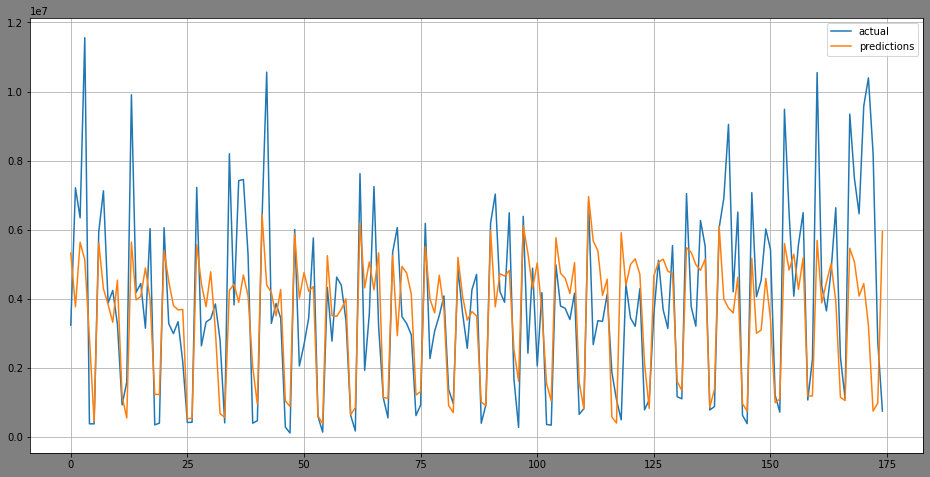

In [50]:
# model = LGBMRegressor(random_state=rs, max_depth=6)
model = LGBMRegressor(random_state=rs, **gs.best_params_)
model.fit(features_train, target_train)

n_scores = pd.DataFrame(cval(model, features_train, target_train, cv=tscv.n_splits, scoring=('neg_mean_squared_error'), 
                                return_train_score=True)).abs()
target_pred = pd.DataFrame(cvp(model, features_test, target_test, cv=tscv.n_splits))
train_pred = pd.DataFrame(cvp(model, features_train, target_train, cv=tscv.n_splits))

train_RMSE = n_scores.train_score.mean() ** 0.5
valid_RMSE = n_scores.test_score.mean() ** 0.5
test_RMSE = mean_squared_error(target_test, target_pred) ** 0.5

print(f'RMSE на обучающей выборке: {train_RMSE}')
print(f'RMSE на валидационной выборке: {valid_RMSE}')
print(f'RMSE предсказание на тестовой выборке: {test_RMSE}')
print(f'RMSE предсказание на train: {mean_squared_error(target_train, train_pred) ** 0.5}')

plt.figure(figsize=(16,8), facecolor='gray')
plt.plot(target_test.values[:200], label='actual')
plt.plot(target_pred[:200], label='predictions')
plt.legend(loc='best')
plt.grid()

In [51]:
%%time
cat = CatBoostRegressor(random_state=rs, verbose=False)
params = {'n_estimators': [i for i in range(50, 200, 10)],
          'learning_rate': [i for i in np.arange(0.001, 0.1, 0.001)],
          'max_depth': [i for i in range(2, 7, 1)]}

gs_cat = GridSearchCV(cat, params, scoring=('neg_mean_squared_error'), n_jobs=-1, cv=5)
gs_cat.fit(features_train, target_train)

Wall time: 53min 6s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001FE8CBA9EB0>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.002, 0.003, 0.004, 0.005,
                                           0.006, 0.007, 0.008,
                                           0.009000000000000001,
                                           0.010000000000000002, 0.011, 0.012,
                                           0.013000000000000001,
                                           0.014000000000000002, 0.015, 0.016,
                                           0.017, 0.018000000000000002,
                                           0.019000000000000003, 0.02, 0.021,
                                           0.022000000000000002, 0.023, 0.024,
                                           0.025, 0.026000000000000002,
                                           0.027000000000000003, 0.028, 0.029,
                                           0.030000000000000

In [52]:
gs_cat.best_params_

{'learning_rate': 0.058, 'max_depth': 3, 'n_estimators': 170}

RMSE на обучающей выборке: 3894369.0818385817
RMSE на валидационной выборке: 5757282.286265962
RMSE предсказание на тестовой выборке: 1930333.264634807
RMSE предсказание на train: 5759908.006506711


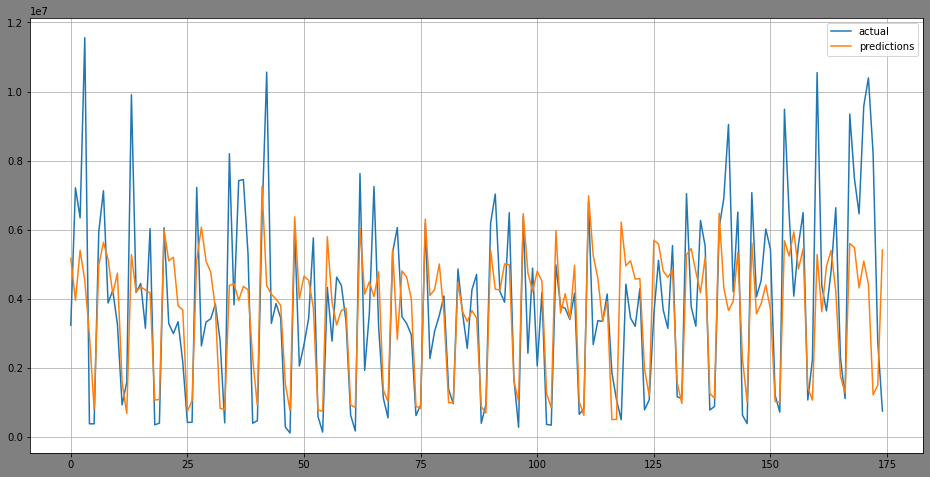

In [53]:
model = CatBoostRegressor(random_state=rs, **gs_cat.best_params_, verbose=False)
model.fit(features_train, target_train)

n_scores = pd.DataFrame(cval(model, features_train, target_train, cv=tscv.n_splits, scoring=('neg_mean_squared_error'), 
                                return_train_score=True)).abs()
target_pred = pd.DataFrame(cvp(model, features_test, target_test, cv=tscv.n_splits))
train_pred = pd.DataFrame(cvp(model, features_train, target_train, cv=tscv.n_splits))

train_RMSE = n_scores.train_score.mean() ** 0.5
valid_RMSE = n_scores.test_score.mean() ** 0.5
test_RMSE = mean_squared_error(target_test, target_pred) ** 0.5

print(f'RMSE на обучающей выборке: {train_RMSE}')
print(f'RMSE на валидационной выборке: {valid_RMSE}')
print(f'RMSE предсказание на тестовой выборке: {test_RMSE}')
print(f'RMSE предсказание на train: {mean_squared_error(target_train, train_pred) ** 0.5}')

plt.figure(figsize=(16,8), facecolor='gray')
plt.plot(target_test.values[:200], label='actual')
plt.plot(target_pred[:200], label='predictions')
plt.legend(loc='best')
plt.grid()

## <a id=section03>3. Итоговый вывод</a>

Хорошее предсказание в области ям. Здесь в моделях очень хорошо предсказания совпадают с тестовыми данными. При этом вершины очень плохо модель предсказывает. Не успел разобраться в чем причина.